# Basic example on how to run the `Ellipse` fitting tool

The image of the M51 galaxy formerly distributed with the IRAF software was used extensively before as a regression test for the old STSDAS 'ellipse' task. We reuse it here for the sake of consistency.

Note that M51, with its prominent spiral arms and giant HII regions, is not the best subject for science analysis by the 'ellipse' algorithm, since it assumes that isophotes are mainly elliptical in shape. On the other hand, the M51 image is ideal for checking the resilience of the algorithm against image contamination by non-elliptical features.

See the `isophote_example3.ipynb` notebook for an example where we apply the `Ellipse` tool to an image of a "true" elliptical galaxy.

In [1]:
from astropy.io import fits
from astropy.utils.data import download_file

url = 'https://github.com/astropy/photutils-datasets/raw/main/data/isophote/M51.fits'
path = download_file(url)
hdu = fits.open(path)
data = hdu[0].data
hdu.close()

Next, we create an instance of the `Ellipse` class, passing the 2D numpy array with the pixel data as argument to the constructor:

In [2]:
from photutils.isophote import Ellipse

ellipse = Ellipse(data)

Finally, we run the `fit_image` method on the instance, getting an instance of the `IsophoteList` class.

This may take a while.  This interpreted version of the algorithm is significantly slower than the old, compiled code in the IRAF system. In this implementation, we trade speed for flexibility. 

In [3]:
isolist = ellipse.fit_image()

We can display the results as an Astropy Table using the `to_table()` method.

In [4]:
isolist.to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad_rerr,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,
float64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,int64
0.0,7599.35398008,0.0,0.0,0.0,0.0,0.0,None,1,0,0,0
0.520986848192,6873.38534119,22.022121332,0.0420433206106,0.0271760927596,150.87791040667994,20.200495090481986,0.394789770247,13,0,10,0
0.573085533012,6788.08817537,23.8087089612,0.0406454398175,0.0261238001884,136.632045384713,20.069928828826825,0.368636240348,13,0,10,0
0.630394086313,6706.47449113,26.4300568042,0.0543576227285,0.026433926692,143.9545111835206,15.292199203660783,0.376835586165,13,0,10,0
0.693433494944,6605.62346224,26.9130728248,0.0543576227285,0.0246453327138,140.2141827872746,14.257351785430332,0.352467015127,13,0,10,0
0.762776844439,6505.07111702,27.8646393183,0.0646029360467,0.0238962330191,133.87119369286359,11.693273369238181,0.353327275928,13,0,10,0
0.839054528882,6393.16943678,30.6047364559,0.0699801250922,0.0219464808479,139.5638352457548,9.941822771692594,0.298197181842,13,0,10,0
0.922959981771,6242.94267019,32.388211917,0.0427636166768,0.0195353181998,119.87398983432568,14.280180684997452,0.266964038604,13,0,50,2


Check the result's type, it should be an instance of the `IsophoteList` class:

In [5]:
type(isolist)

photutils.isophote.isophote.IsophoteList

### Running `Ellipse` in a finer-grained way:

We can fit individual ellipses as well, by just calling the `fit_isophote` method in the same `Ellipse` instance (passing the semimajor axis length to the method):

In [6]:
isophote = ellipse.fit_isophote(sma=20.)

isophote.to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad_rerr,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64
20.0,734.422137057,7.14077791759,0.185897830313,0.00229118933959,34.04174791972561,0.3957647029112029,0.115171552352,114,0,13,0


Note that in this case we get an instance of the `Isophote` class, not `IsophoteList` as before:

In [7]:
type(isophote)

photutils.isophote.isophote.Isophote

Regarding the example above, one may think that calling the `fit_isophote` method in a simple `for` loop with successive values of the semimajor axis length will emulate the `fit_image` method.  However, that would not be the case in general. The algorithm will probably stop prematurely, and/or will not result in the best fit. The fitting algorithm is quite sensitive to the initial guesses (the starting ellipse geometry) and other fitting parameters such as the step used to move from a given ellipse to the next, the area integration method, finding the maximum acceptable semimajor axis length, and such. The `fit_image` method takes care of handling these details in a transparent way for the user.

In the `photutils.isophote` package, the class constructors and method calls accept a variety of parameters that can be used to customize and fine tune the fit process. Here we give a few examples; please see the code documentation for a complete description. 

For instance, the fit algorithm is quite sensitive to the initial guesses for the `X` and `Y` position of the center of the galaxy on the frame. When using default values as in the examples above, the methods assume that the galaxy is exactly centered in the frame. The fit algorithm can also fail to properly converge if either the ellipticity or the position angle of the semi-major axis are too way off the true values. To override the default values, we can initialize the `Ellipse` constructor with an `EllipeGeometry` instance. This class encapsulates all data and behavior associated with a given ellipse's geometry.

In [8]:
import numpy as np
from photutils.isophote import EllipseGeometry

# user defines here the geometry parameters that will be used as first guess.
x0 = 256.    # center position
y0 = 256.    # center position
sma = 20.    # semimajor axis length in pixels
eps = 0.2    # ellipticity

# positon angle is defined in radians, counterclockwise from the
# +X axis (rotating towards the +Y axis). Here we use 35 degrees 
# as a first guess.
pa = 35. / 180. * np.pi

# note that the EllipseGeometry constructor has additional parameters with
# default values. Please see the documentation for details.
g = EllipseGeometry(x0, y0, sma, eps, pa)

# the custom geometry is passed to the Ellipse constructor.
ellipse = Ellipse(data, geometry=g)

# the fit proceeds as usual.
isophote = ellipse.fit_isophote(sma=20.)

print(isophote)

sma      intens      intens_err   ellipticity   ... ndata flag niter stop_code
                                                ...                           
---- ------------- ------------- -------------- ... ----- ---- ----- ---------
20.0 733.621466341 7.23111016206 0.184271226625 ...   114    0    10         0


To further break down the fit process, one could explictly work with the `EllipseSample` and `EllipseFitter` classes.

Here, we initially create an instance of the `EllipseSample` class. This instance encapsulates everything associated with a given elliptical path over the image. This includes not only the geometry information, but also the raw intensity samples extracted from the image (intensity as a function of polar angle and radius), as well as associated statistical quantities. 

Note that the `EllipseSample` constructor allows for overriding the semimajor axis length initially used to create the `EllipseGeometry` instance. That way, one can propagate a given geometry configuration to other samples taken at other values of semimajor axis length.

The `EllipseSample` instance is used to initialize an instance of the `EllipseFitter` class. This class has a number of controls to help in tweaking the fit. The final result of the `fit` method is an instance of `Isophote` with the final, fitted values of the geometry parameters.

In [9]:
from photutils.isophote import EllipseSample, EllipseFitter

sample = EllipseSample(data, 7., geometry=g)
fitter = EllipseFitter(sample)
isophote = fitter.fit()

print(isophote)

sma     intens      intens_err    ellipticity   ... ndata flag niter stop_code
                                                ...                           
--- ------------- ------------- --------------- ... ----- ---- ----- ---------
7.0 1285.65377863 8.22319124117 0.0820469573325 ...    43    0    10         0


Raw values extracted from the image can be accessed via the `values` attribute of an `EllipseSample` instance. This attribute holds a 2D numpy array. The first element is of length 3, and each one of those has as many elements as there are individual extracted values from the image.

In [10]:
isophote.sample.values.shape

(3, 43)

The 3 top-level elements contain respectively the position angles, the polar radii, and the intensity values extracted at each position along the elliptical path on the image:

In [11]:
# angles in radians
isophote.sample.values[0]

array([ 0.05      ,  0.19289046,  0.33623695,  0.48053888,  0.62621849,
        0.77358639,  0.9228136 ,  1.07391264,  1.22673067,  1.38095689,
        1.53614602,  1.69175709,  1.84720446,  2.0019156 ,  2.15538816,
        2.307239  ,  2.45723918,  2.60533132,  2.75162918,  2.89640124,
        3.04004223,  3.1830364 ,  3.32591644,  3.46922097,  3.61345284,
        3.75903992,  3.90630038,  4.05541422,  4.20640381,  4.35912613,
        4.51327936,  4.66842532,  4.82402743,  4.97950115,  5.13427149,
        5.2878304 ,  5.43978649,  5.58990087,  5.73810576,  5.88450495,
        6.02935839,  6.17305419,  6.31607238])

In [12]:
# polar radii in pixels
isophote.sample.values[1]

array([ 6.99836787,  6.97610385,  6.92991435,  6.86437845,  6.78573813,
        6.70119113,  6.61817537,  6.54373067,  6.48398177,  6.44375004,
        6.42627816,  6.43304535,  6.46365874,  6.51582306,  6.58540957,
        6.66665887,  6.75255257,  6.83537024,  6.90740995,  6.96180107,
        6.99329231,  6.99887826,  6.97814611,  6.9332807 ,  6.86874115,
        6.7906891 ,  6.70628558,  6.62297317,  6.5478314 ,  6.48705197,
        6.44554312,  6.42664808,  6.43195547,  6.4611863 ,  6.51215841,
        6.5808487 ,  6.66158681,  6.74741591,  6.8306387 ,  6.90352971,
        6.95914541,  6.99211763,  6.99929343])

In [13]:
# intensities
isophote.sample.values[2]

array([ 1279.89474467,  1322.54329135,  1336.37111132,  1307.42148718,
        1257.52049221,  1198.33052443,  1165.56113012,  1209.03453163,
        1307.60129791,  1389.12083209,  1416.31882757,  1380.55221037,
        1301.20924959,  1212.212614  ,  1170.76940475,  1237.58495247,
        1331.98250726,  1336.61024271,  1280.77657259,  1239.33175623,
        1244.67315593,  1280.57378159,  1307.17315058,  1306.25088493,
        1307.34587301,  1273.76064363,  1272.55283808,  1281.76988813,
        1297.71633881,  1312.16525593,  1323.44590343,  1310.68205737,
        1275.2273432 ,  1230.78580131,  1211.09045406,  1251.10266865,
        1310.25520547,  1346.20008783,  1345.88067413,  1317.11716359,
        1268.424169  ,  1252.34663517,  1275.82472664])

Note that in the example above we cannot use the original `EllipseSample` instance that was  used to initialize the fitter. Once the fitter does its bidding, that instance becomes invalid and we need to look for a new `EllipseSample` instance inside the `Isophote` instance just created by the fitter.

## Plotting results:

Import packages necessary for plotting:

In [14]:
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'
%matplotlib inline

The attributes of an `Isophote` instance are also attributes of an `IsophoteList` instance. The difference is, while the individual isophotes have scalar attributes, the same attributes in an `IsophoteList` are numpy arrays that store the given attribute across all isophotes in the list. Thus, attributes in a `IsophoteList` can be directly used as parameters for matplotlib calls.

To ease transition to this new implementation, attribute names were chosen whenever possible to match the names used in the old STSDAS task and its parameter sets.

As an example, a basic plot of magnitude as a function of $($semi-major axis length$)^{1/4}$ can be done simply as:

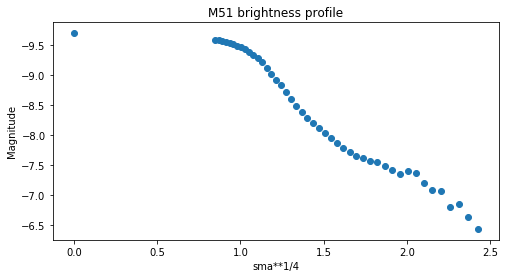

In [15]:
plt.figure(figsize=(8, 4))

plt.scatter(isolist.sma**0.25, -2.5*np.log10(isolist.intens))
plt.title("M51 brightness profile")
plt.xlabel('sma**1/4')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()

Next, a multiple plot depicting ellipse geometry as a function of semimajor axis length:

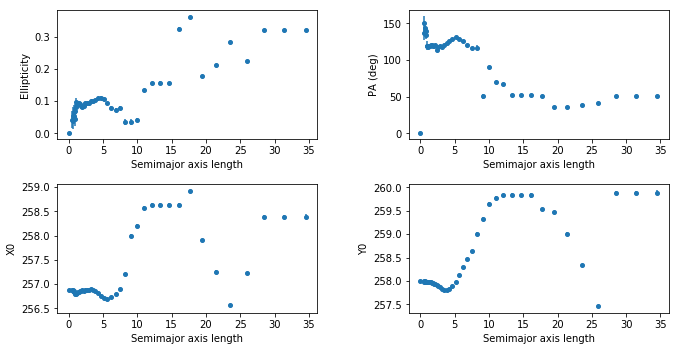

In [16]:
plt.figure(figsize=(10, 5))
plt.figure(1)

plt.subplot(221)
plt.errorbar(isolist.sma, isolist.eps, yerr=isolist.ellip_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('Ellipticity')

plt.subplot(222)
plt.errorbar(isolist.sma, isolist.pa/np.pi*180., yerr=isolist.pa_err/np.pi* 80., fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('PA (deg)')

plt.subplot(223)
plt.errorbar(isolist.sma, isolist.x0, yerr=isolist.x0_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('X0')

plt.subplot(224)
plt.errorbar(isolist.sma, isolist.y0, yerr=isolist.y0_err, fmt='o', markersize=4)
plt.xlabel('Semimajor axis length')
plt.ylabel('Y0')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)

Ellipses can be overplotted on the image display:

Closest SMA = 34.522712


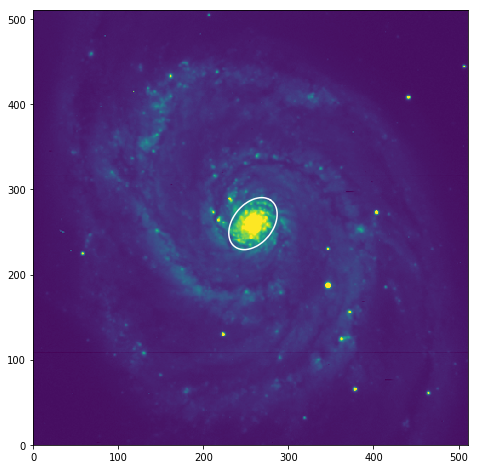

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(data, vmin=0, vmax=1000)
plt.axis([0, 511, 0, 511])

# this method on an IsophoteList instance will retrieve the isophote 
# that has the closest 'sma' from the passed argument.
iso = isolist.get_closest(40.)
print('Closest SMA = {:f}'.format(iso.sma))

# this method on an Isophote instance returns the (x, y) coordinates of 
# the sampled points in the image.
x, y, = iso.sampled_coordinates()

plt.plot(x, y, color='white')

The "isophote" doesn't look quite isophotal. This is to be expected in this image though. The fitting algorithm assumes that a smooth surface brightness distribution will dominate the image, and this is hardly the case of M51 with its prominent spiral arms and lots of clumpy star formation regions. 

In another notebook (`isophote_example3.ipynb`) we demonstrate the behavior of these algorithms when applied to an image of a true elliptical galaxy.

We can examine the elliptical brightness sample associated with the ellipse depicted above to get an idea of what is going on. The plot below shows large contamination from those bright HII regions.

Text(0.5,0,'Angle (deg)')

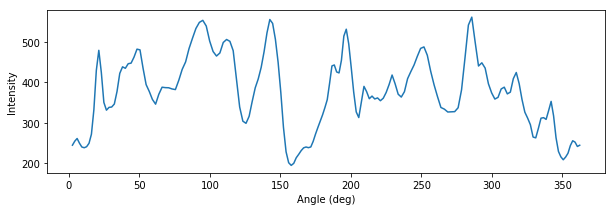

In [18]:
plt.figure(figsize=(10, 3))
plt.plot(iso.sample.values[0] / np.pi*180., iso.sample.values[2])
plt.ylabel("Intensity")
plt.xlabel("Angle (deg)")

We can use sigma-clipping to try to mitigate them. Please see the `isophote_example2.ipynb` notebook for a demo of the sigma-clipping feature.